In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import librosa.display
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


In [2]:
accuracy = []
precision = []
recall = []
fscore = []

model_folder = "model"

In [3]:

def remove_noise(audio, sr):
    noise_profile = audio[:int(0.5 * sr)]
    noise_reduced_audio = librosa.effects.remix(audio, intervals=librosa.effects.split(audio, top_db=20))
    return noise_reduced_audio

In [4]:
def load_audio_with_features(path, categories, model_folder):
    X_file = os.path.join(model_folder, "X.npy")
    Y_file = os.path.join(model_folder, "Y.npy")

    if os.path.exists(X_file) and os.path.exists(Y_file):
        print(f"Loading cached data from {model_folder}")
        X = np.load(X_file)
        Y = np.load(Y_file)
    else:
        print(f"Path does not exist: {path}" if not os.path.exists(path) else "Processing directory")
        X = []
        Y = []

        for root, dirs, files in os.walk(path):
            print(f"Processing root: {root}")
            for file in files:
                name = os.path.basename(root)
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    print(file_path)
                    try:
                        y, sr = librosa.load(file_path, sr=None)  # Load the audio file

                        # Extracting 10 different features
                        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30).T, axis=0)
                        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
                        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
                        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
                        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
                        rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
                        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
                        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
                        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
                        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)

                        # Concatenating features into a single vector
                        feature_vector = np.hstack([
                            mfccs, chroma, mel, spectral_contrast, tonnetz,
                            rms, spectral_bandwidth, spectral_centroid, spectral_rolloff, zero_crossing_rate
                        ])

                        X.append(feature_vector)
                        if name in categories:
                            Y.append(categories.index(name))
                        else:
                            print(f"Category {name} not in categories list.")
                    except Exception as e:
                        print(f"Skipping {file_path}, error reading file: {e}")

        X = np.array(X)
        Y = np.array(Y)
        os.makedirs(model_folder, exist_ok=True)  # Ensure the directory exists
        np.save(X_file, X)
        np.save(Y_file, Y)

    return X, Y

In [5]:
def Upload_Dataset():
    global filename, categories
    filename = "dataset"
    categories = [d for d in os.listdir(filename) if os.path.isdir(os.path.join(filename, d))]
    print('Dataset loaded')
    print("Classes found in dataset:", categories)

In [6]:
def Preprocess_Dataset():
    global X, Y, filename, categories, df

    path = filename
    X, Y = load_audio_with_features(path, categories, model_folder)

    print(f"Preprocessing and MFCC Feature Extraction completed on Dataset: {filename}")
    print(f"Input MFCC Feature Set Size: {X.shape}")

    X_list = X.tolist()
    Y_list = Y.tolist()
    df = pd.DataFrame({'X': X_list, 'Y': Y_list})

    # Plot the counts of each category
    category_counts = {category: len(os.listdir(os.path.join(path, category))) for category in categories}
    df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

    plt.figure(figsize=(10, 6))
    plt.bar(df_counts['Category'], df_counts['Count'], color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Number of Sounds per Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [7]:
def Train_Test_Splitting():
    global X, Y
    global x_train, y_train, x_test, y_test

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    # Display information about the dataset
    print("Total records found in dataset:", X.shape[0])
    print("Total records found in dataset to train:", x_train.shape[0])
    print("Total records found in dataset to test:", x_test.shape[0])

In [8]:
def Calculate_Metrics(algorithm, predict, y_test):
    global categories

    a = accuracy_score(y_test, predict) * 100
    p = precision_score(y_test, predict, average='macro') * 100
    r = recall_score(y_test, predict, average='macro') * 100
    f = f1_score(y_test, predict, average='macro') * 100

    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)

    print(f"{algorithm} Accuracy  : {a}")
    print(f"{algorithm} Precision : {p}")
    print(f"{algorithm} Recall    : {r}")
    print(f"{algorithm} FScore    : {f}")

    conf_matrix = confusion_matrix(y_test, predict)
    CR = classification_report(y_test, predict, target_names=categories)

    print(f"{algorithm} Classification Report:\n{CR}\n")

    plt.figure(figsize=(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels=categories, yticklabels=categories, annot=True, cmap="viridis", fmt="g")
    ax.set_ylim([0, len(categories)])
    plt.title(f"{algorithm} Confusion Matrix") 
    plt.ylabel('True Class') 
    plt.xlabel('Predicted Class') 
    plt.show()

In [9]:
def existing_classifier3():
    global x_train,y_train,x_test,y_test

    path = 'model/LRC'
    if(os.path.exists(path)):
        mlpc = joblib.load(path) 
    else:
        mlpc = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
        mlpc.fit(x_train, y_train)
        joblib.dump(mlpc,path)
    y_pred = mlpc.predict(x_test)
    Calculate_Metrics("Existing LRC", y_pred, y_test)

In [10]:
def proposed_classifier1():
    
    global x_train,y_train,x_test,y_test,knn
    
    path = 'model/KNN'
    if(os.path.exists(path)):
        knn = joblib.load(path) 
    else:
        knn = KNeighborsClassifier()
        knn.fit(x_train, y_train)
        joblib.dump(mlpc,path)
    y_pred = knn.predict(x_test)
    Calculate_Metrics("Proposed KNN Classifier", y_pred, y_test)


In [11]:
def preprocess_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=None)

        # Extracting 10 different features
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr).T, axis=0)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)

        # Concatenating features into a single vector
        feature_vector = np.hstack([
            mfccs, chroma, mel, spectral_contrast, tonnetz,
            rms, spectral_bandwidth, spectral_centroid, spectral_rolloff, zero_crossing_rate
        ])

        return feature_vector

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [12]:
def Prediction(filename):
    global knn, categories

    X_new = preprocess_audio(filename)
    X_new = X_new.reshape(1, -1)

    prediction = knn.predict(X_new)
    predicted_category = categories[prediction[0]]

    print(f"Predicted Outcome From Test Audio is: {predicted_category}\n")

    # Load audio file
    y, sr = librosa.load(filename, sr=None)

    # Create a waveplot
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"Predicted: {predicted_category}")

    # Display the waveplot
    plt.show()

In [13]:
Upload_Dataset()

Dataset loaded
Classes found in dataset: ['Speaker 1', 'Speaker 2', 'Speaker 3', 'Speaker 4', 'Speaker 5']


Loading cached data from model
Preprocessing and MFCC Feature Extraction completed on Dataset: dataset
Input MFCC Feature Set Size: (638, 188)


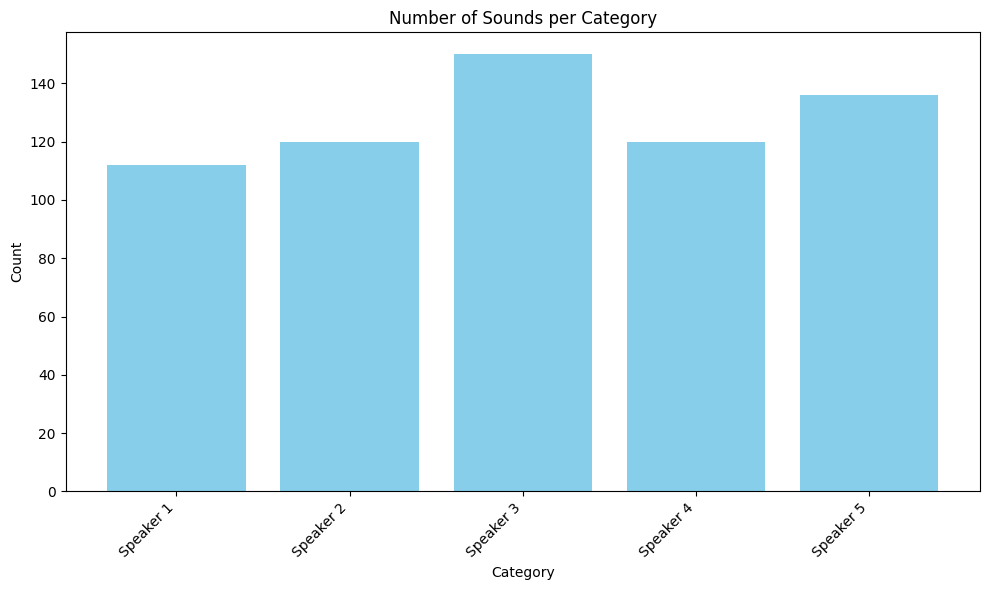

In [14]:
Preprocess_Dataset()

In [15]:
Train_Test_Splitting()

Total records found in dataset: 638
Total records found in dataset to train: 510
Total records found in dataset to test: 128


Existing LRC Accuracy  : 92.96875
Existing LRC Precision : 93.06230001882176
Existing LRC Recall    : 92.6227208976157
Existing LRC FScore    : 92.60702959830866
Existing LRC Classification Report:
              precision    recall  f1-score   support

   Speaker 1       0.90      0.83      0.86        23
   Speaker 2       0.87      1.00      0.93        20
   Speaker 3       1.00      1.00      1.00        31
   Speaker 4       1.00      0.87      0.93        23
   Speaker 5       0.88      0.94      0.91        31

    accuracy                           0.93       128
   macro avg       0.93      0.93      0.93       128
weighted avg       0.93      0.93      0.93       128




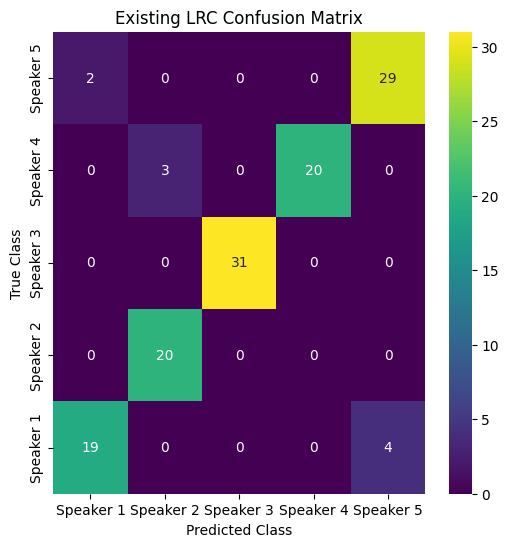

In [16]:
existing_classifier3()

Proposed KNN Classifier Accuracy  : 100.0
Proposed KNN Classifier Precision : 100.0
Proposed KNN Classifier Recall    : 100.0
Proposed KNN Classifier FScore    : 100.0
Proposed KNN Classifier Classification Report:
              precision    recall  f1-score   support

   Speaker 1       1.00      1.00      1.00        23
   Speaker 2       1.00      1.00      1.00        20
   Speaker 3       1.00      1.00      1.00        31
   Speaker 4       1.00      1.00      1.00        23
   Speaker 5       1.00      1.00      1.00        31

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128




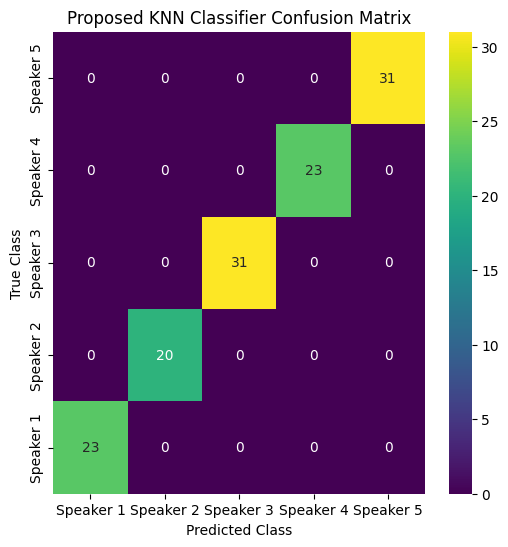

In [17]:
proposed_classifier1()

Predicted Outcome From Test Audio is: Speaker 1



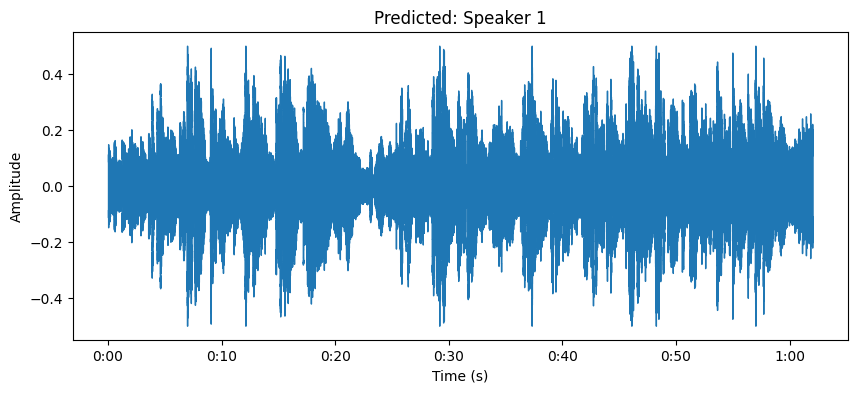

In [18]:
filename=r"test_data\speech (1).wav"
Prediction(filename)

Predicted Outcome From Test Audio is: Speaker 2



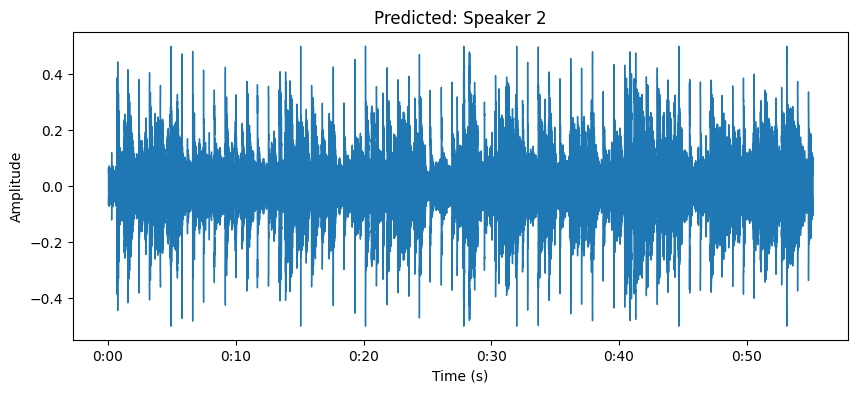

In [19]:
filename=r"test_data\Speech (6).wav"
Prediction(filename)

Predicted Outcome From Test Audio is: Speaker 3



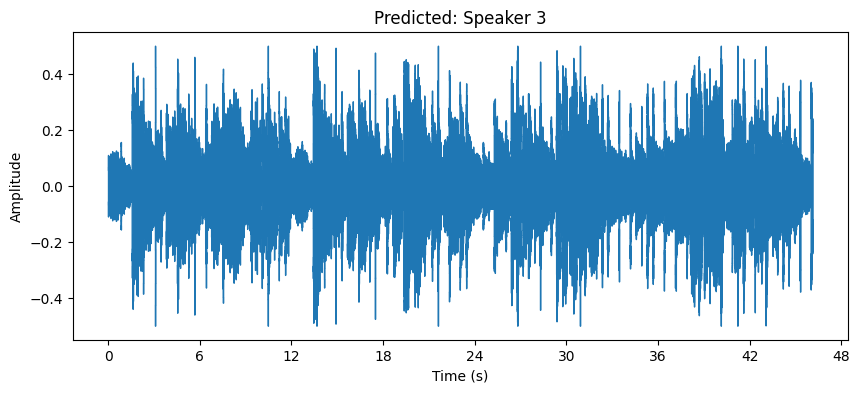

In [20]:
filename=r"test_data\Speech (13).wav"
Prediction(filename)

Predicted Outcome From Test Audio is: Speaker 5



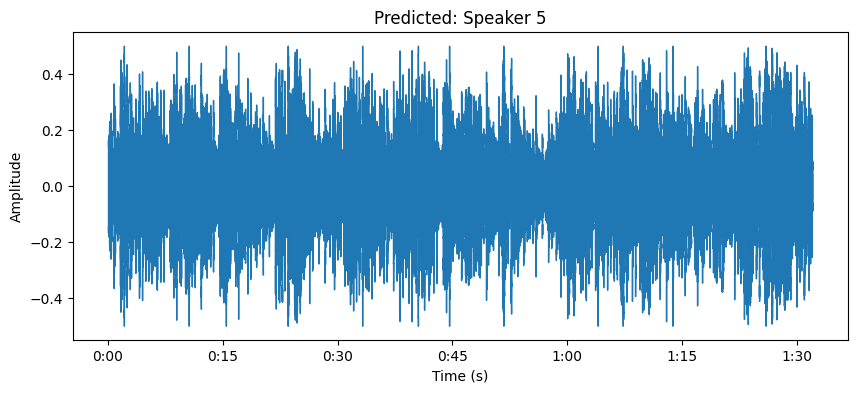

In [21]:
filename=r"test_data\speech (14).wav"
Prediction(filename)